Processing dataset: hist_bias_Q_lq
✓ Loaded: results\hist_bias_Q_lq_0.00.csv
✓ Loaded: results\hist_bias_Q_lq_0.10.csv
✓ Loaded: results\hist_bias_Q_lq_0.20.csv
✓ Loaded: results\hist_bias_Q_lq_0.30.csv
✓ Loaded: results\hist_bias_Q_lq_0.40.csv
✓ Loaded: results\hist_bias_Q_lq_0.50.csv
✓ Loaded: results\hist_bias_Q_lq_0.60.csv
✓ Loaded: results\hist_bias_Q_lq_0.70.csv
✓ Loaded: results\hist_bias_Q_lq_0.80.csv
✓ Loaded: results\hist_bias_Q_lq_0.90.csv
✓ Loaded: results\hist_bias_Q_lq_1.00.csv

✓ Loaded 11 Hist Bias Q Lq levels
✓ Total rows: 11
✓ Hist Bias Q Lq levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


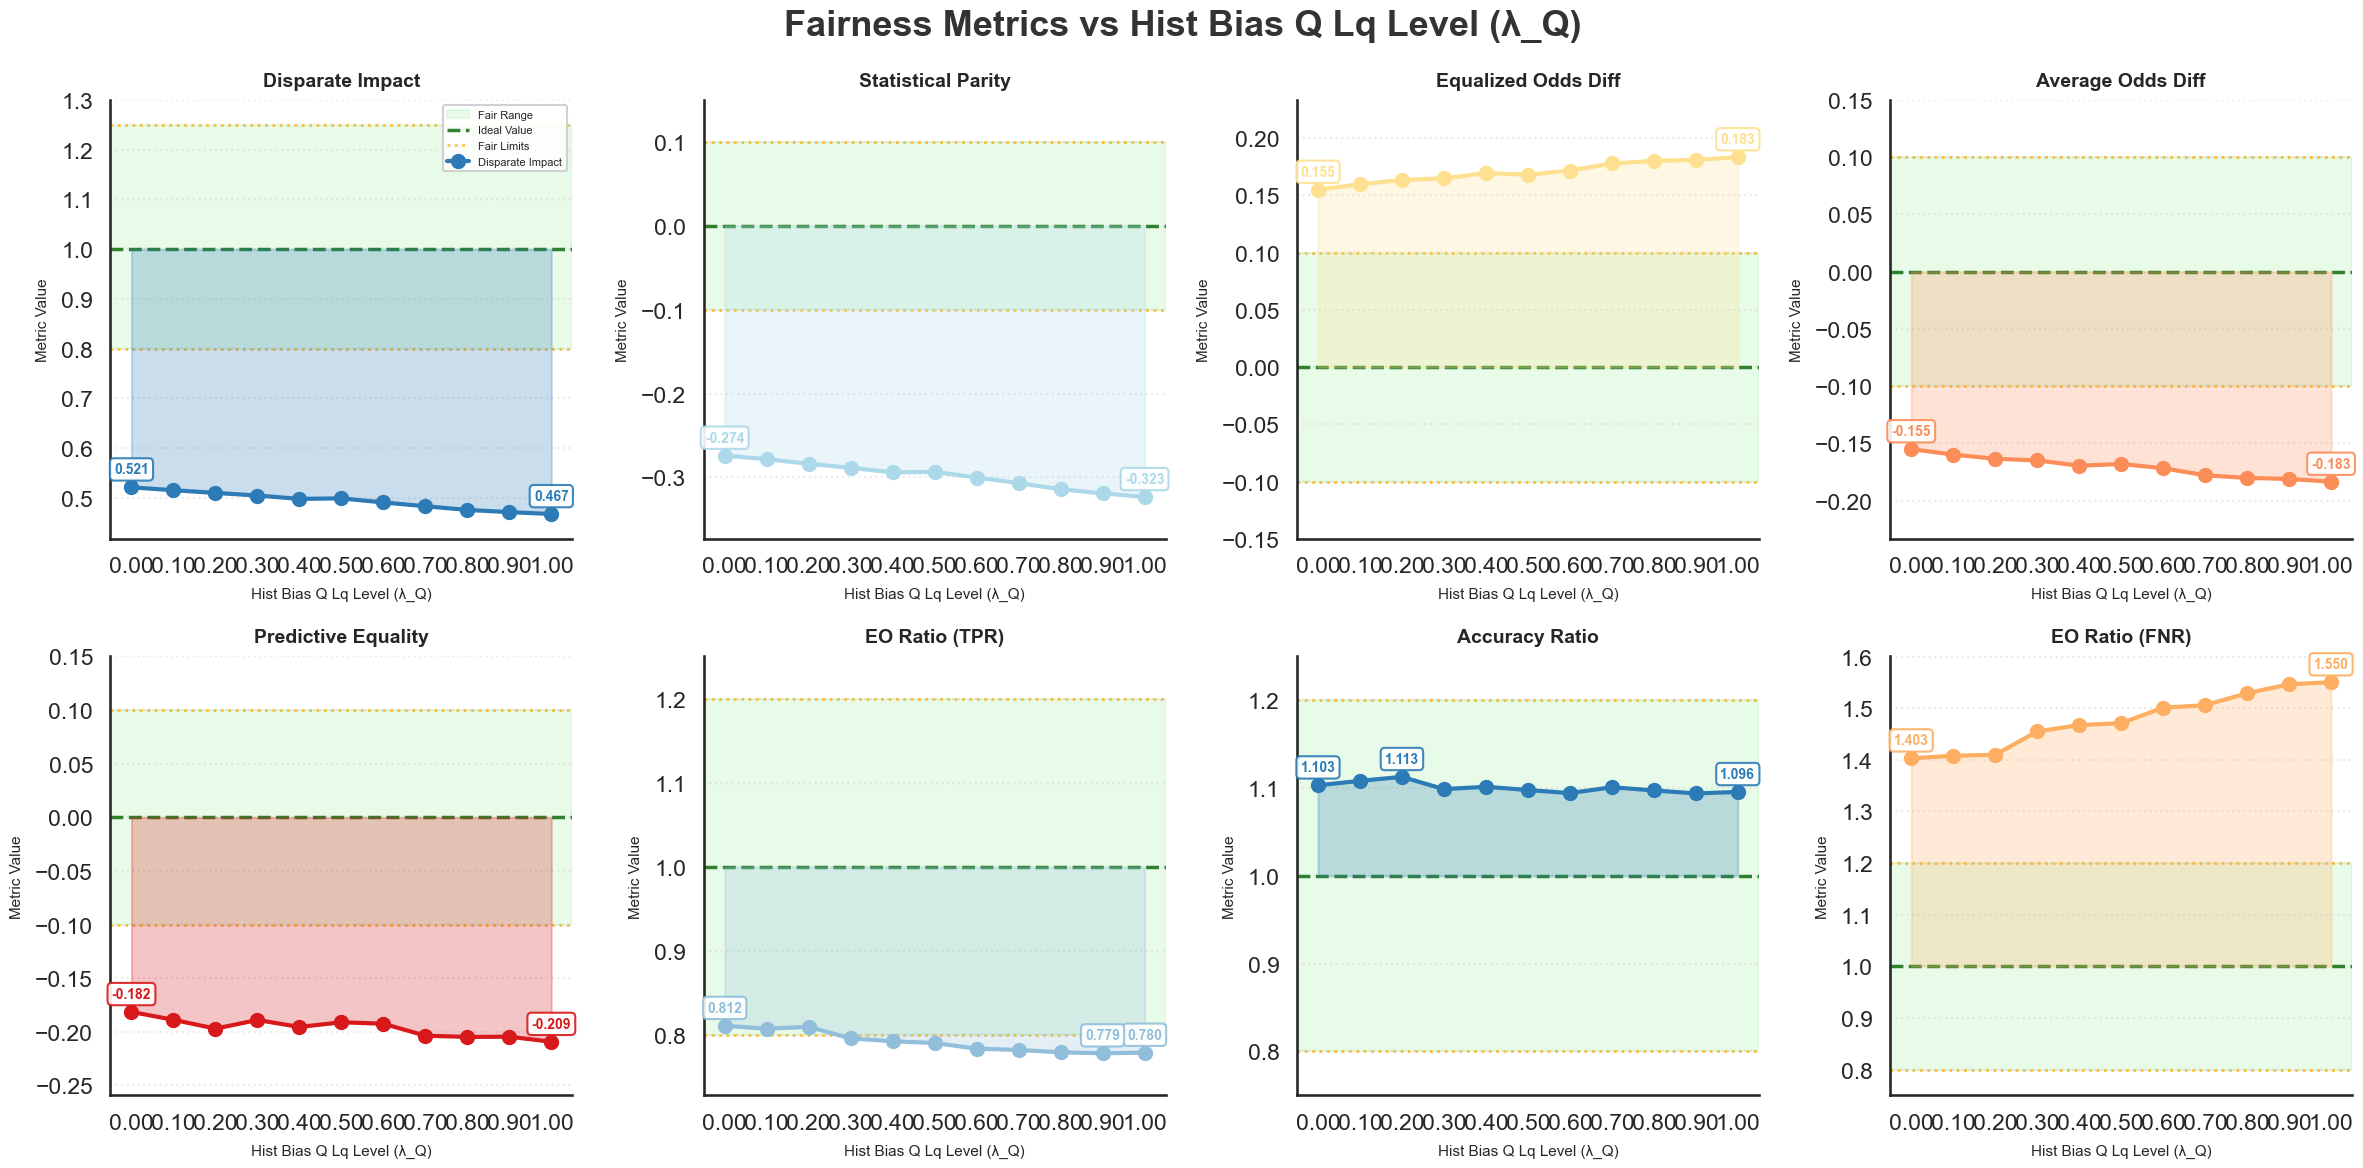

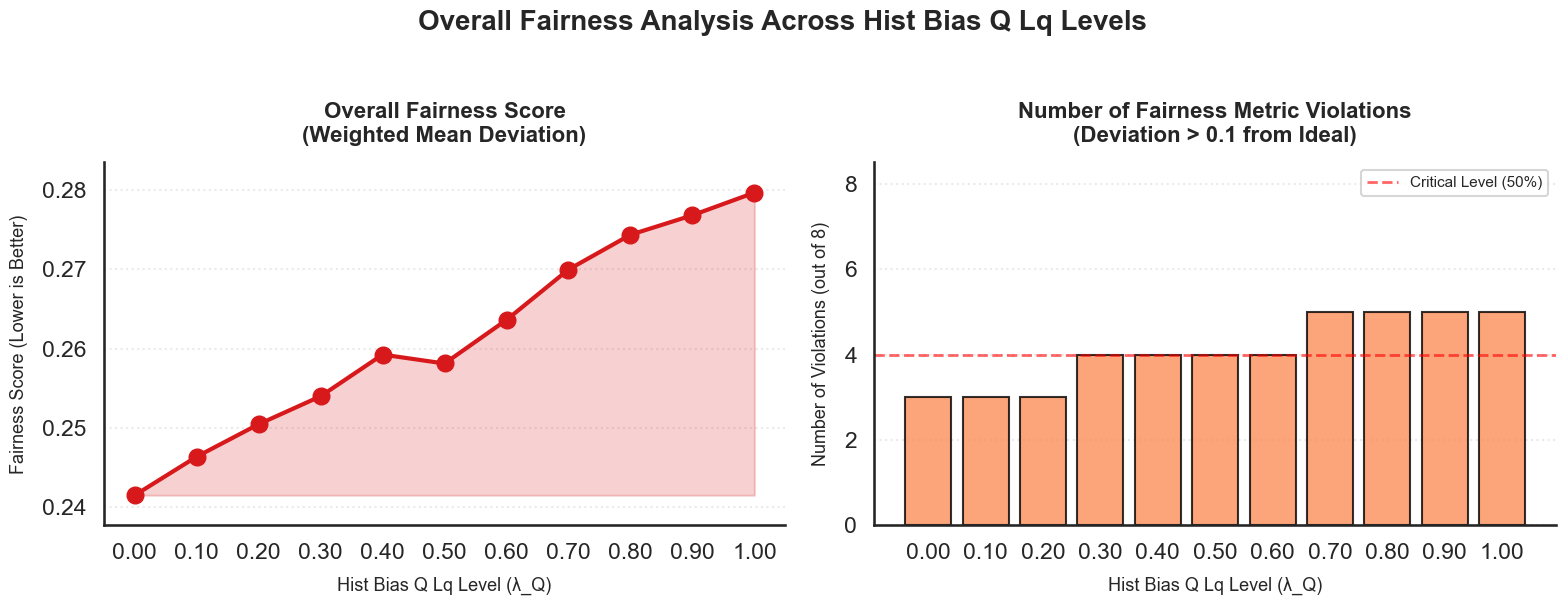

Processing dataset: hist_bias_R_lhr
✓ Loaded: results\hist_bias_R_lhr_0.00.csv
✓ Loaded: results\hist_bias_R_lhr_0.10.csv
✓ Loaded: results\hist_bias_R_lhr_0.20.csv
✓ Loaded: results\hist_bias_R_lhr_0.30.csv
✓ Loaded: results\hist_bias_R_lhr_0.40.csv
✓ Loaded: results\hist_bias_R_lhr_0.50.csv
✓ Loaded: results\hist_bias_R_lhr_0.60.csv
✓ Loaded: results\hist_bias_R_lhr_0.70.csv
✓ Loaded: results\hist_bias_R_lhr_0.80.csv
✓ Loaded: results\hist_bias_R_lhr_0.90.csv
✓ Loaded: results\hist_bias_R_lhr_1.00.csv

✓ Loaded 11 Hist Bias R Lhr levels
✓ Total rows: 11
✓ Hist Bias R Lhr levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


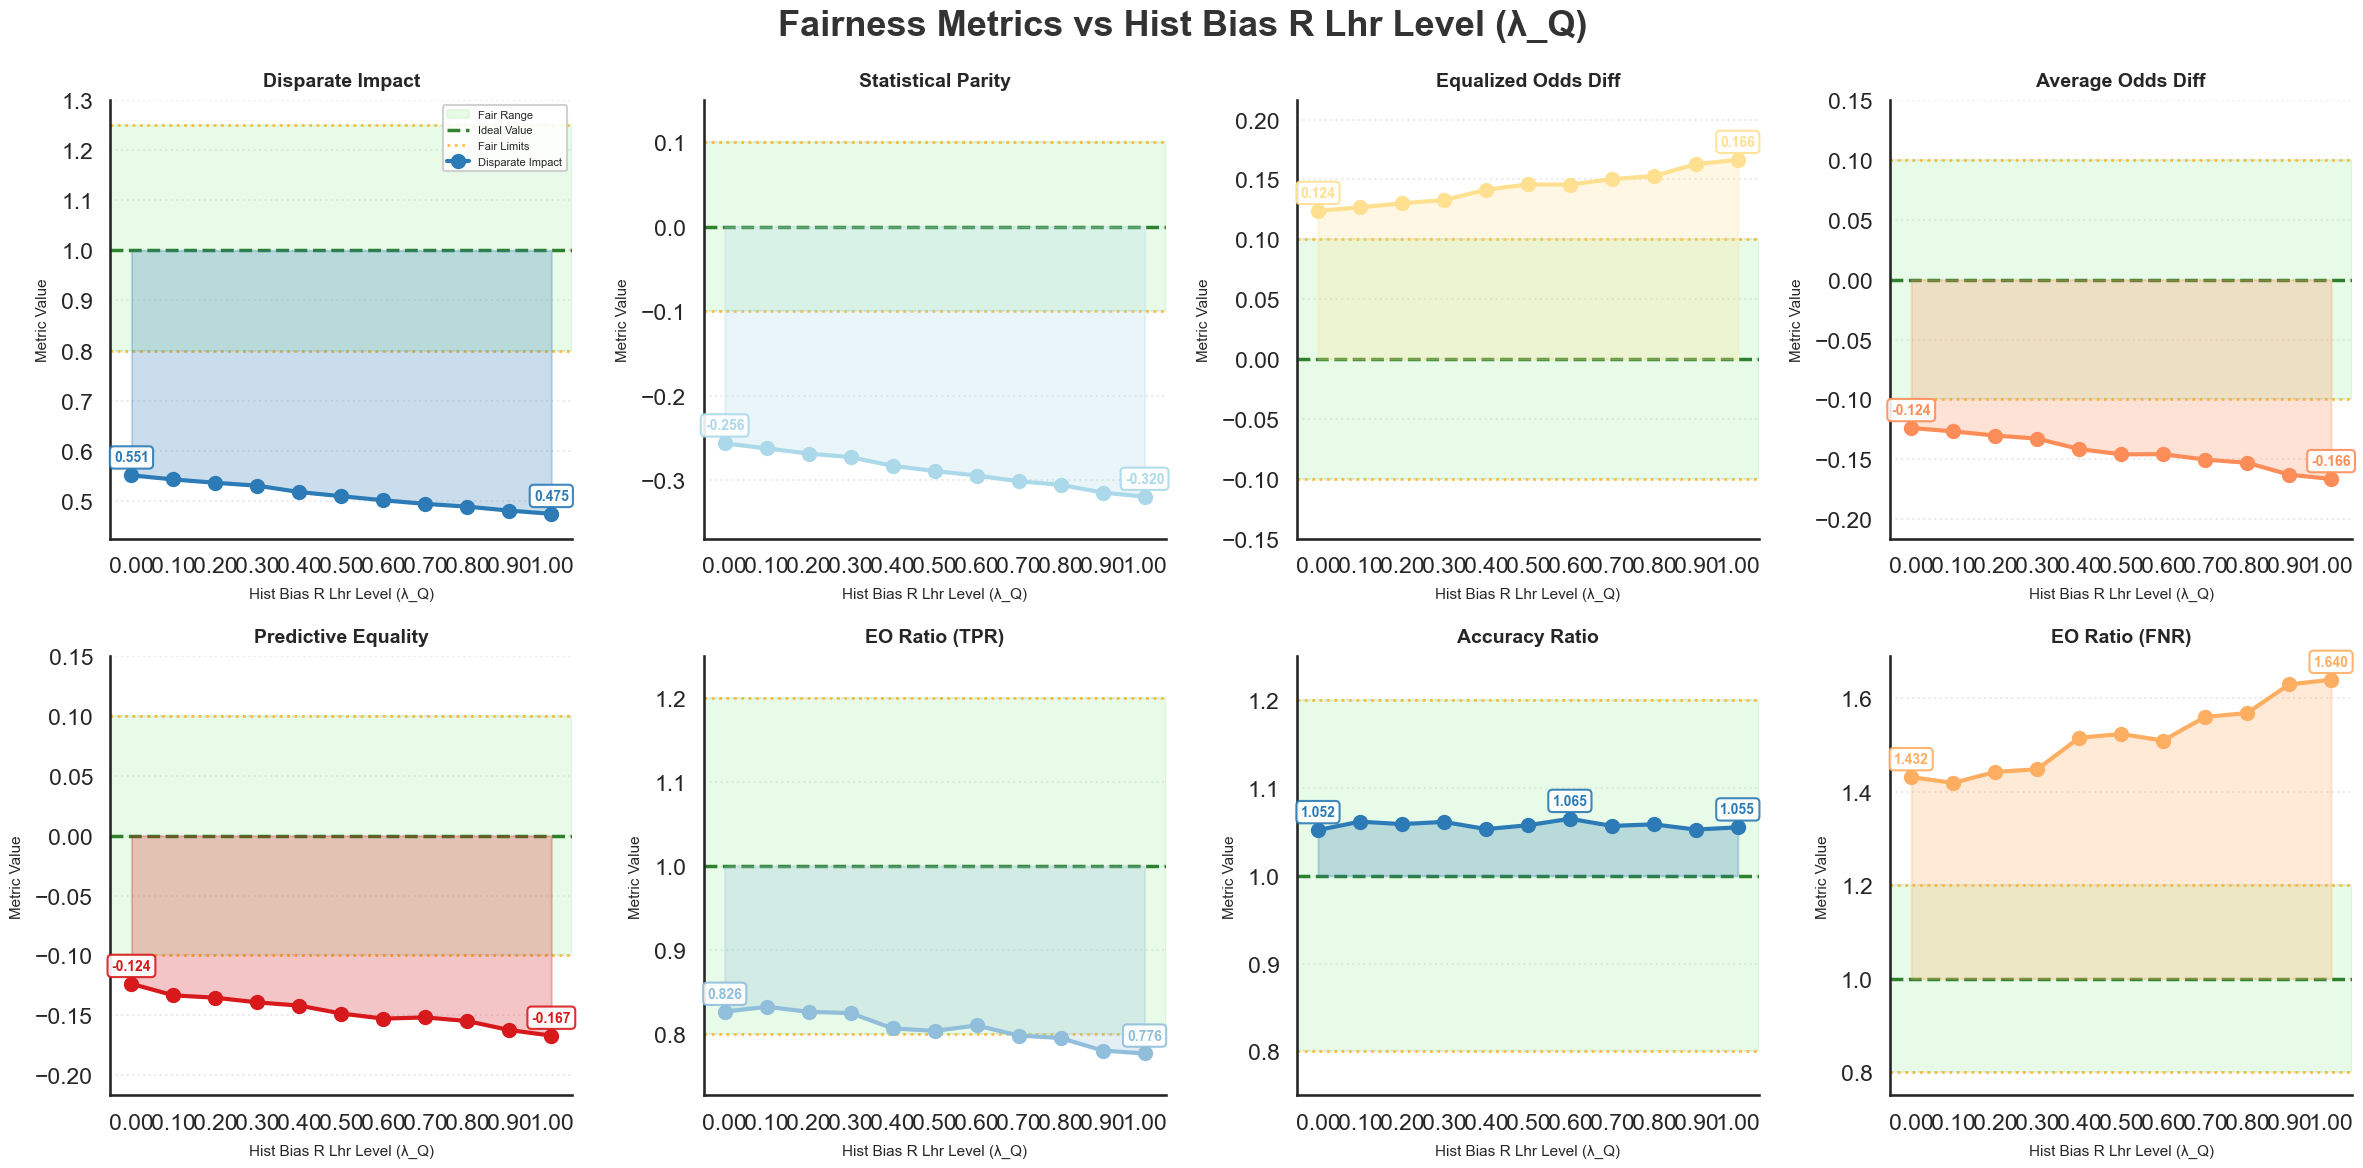

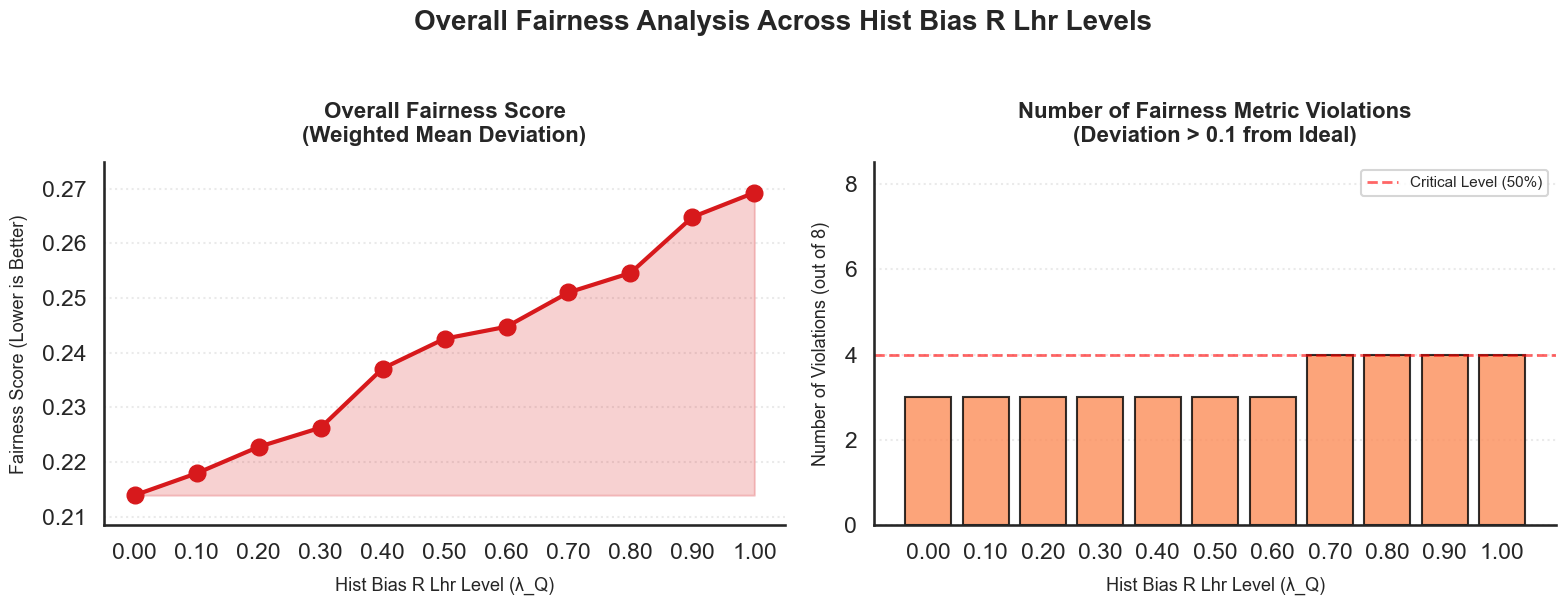

Processing dataset: hist_bias_Y_ly
✓ Loaded: results\hist_bias_Y_ly_0.00.csv
✓ Loaded: results\hist_bias_Y_ly_0.10.csv
✓ Loaded: results\hist_bias_Y_ly_0.20.csv
✓ Loaded: results\hist_bias_Y_ly_0.30.csv
✓ Loaded: results\hist_bias_Y_ly_0.40.csv
✓ Loaded: results\hist_bias_Y_ly_0.50.csv
✓ Loaded: results\hist_bias_Y_ly_0.60.csv
✓ Loaded: results\hist_bias_Y_ly_0.70.csv
✓ Loaded: results\hist_bias_Y_ly_0.80.csv
✓ Loaded: results\hist_bias_Y_ly_0.90.csv
✓ Loaded: results\hist_bias_Y_ly_1.00.csv

✓ Loaded 11 Hist Bias Y Ly levels
✓ Total rows: 11
✓ Hist Bias Y Ly levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


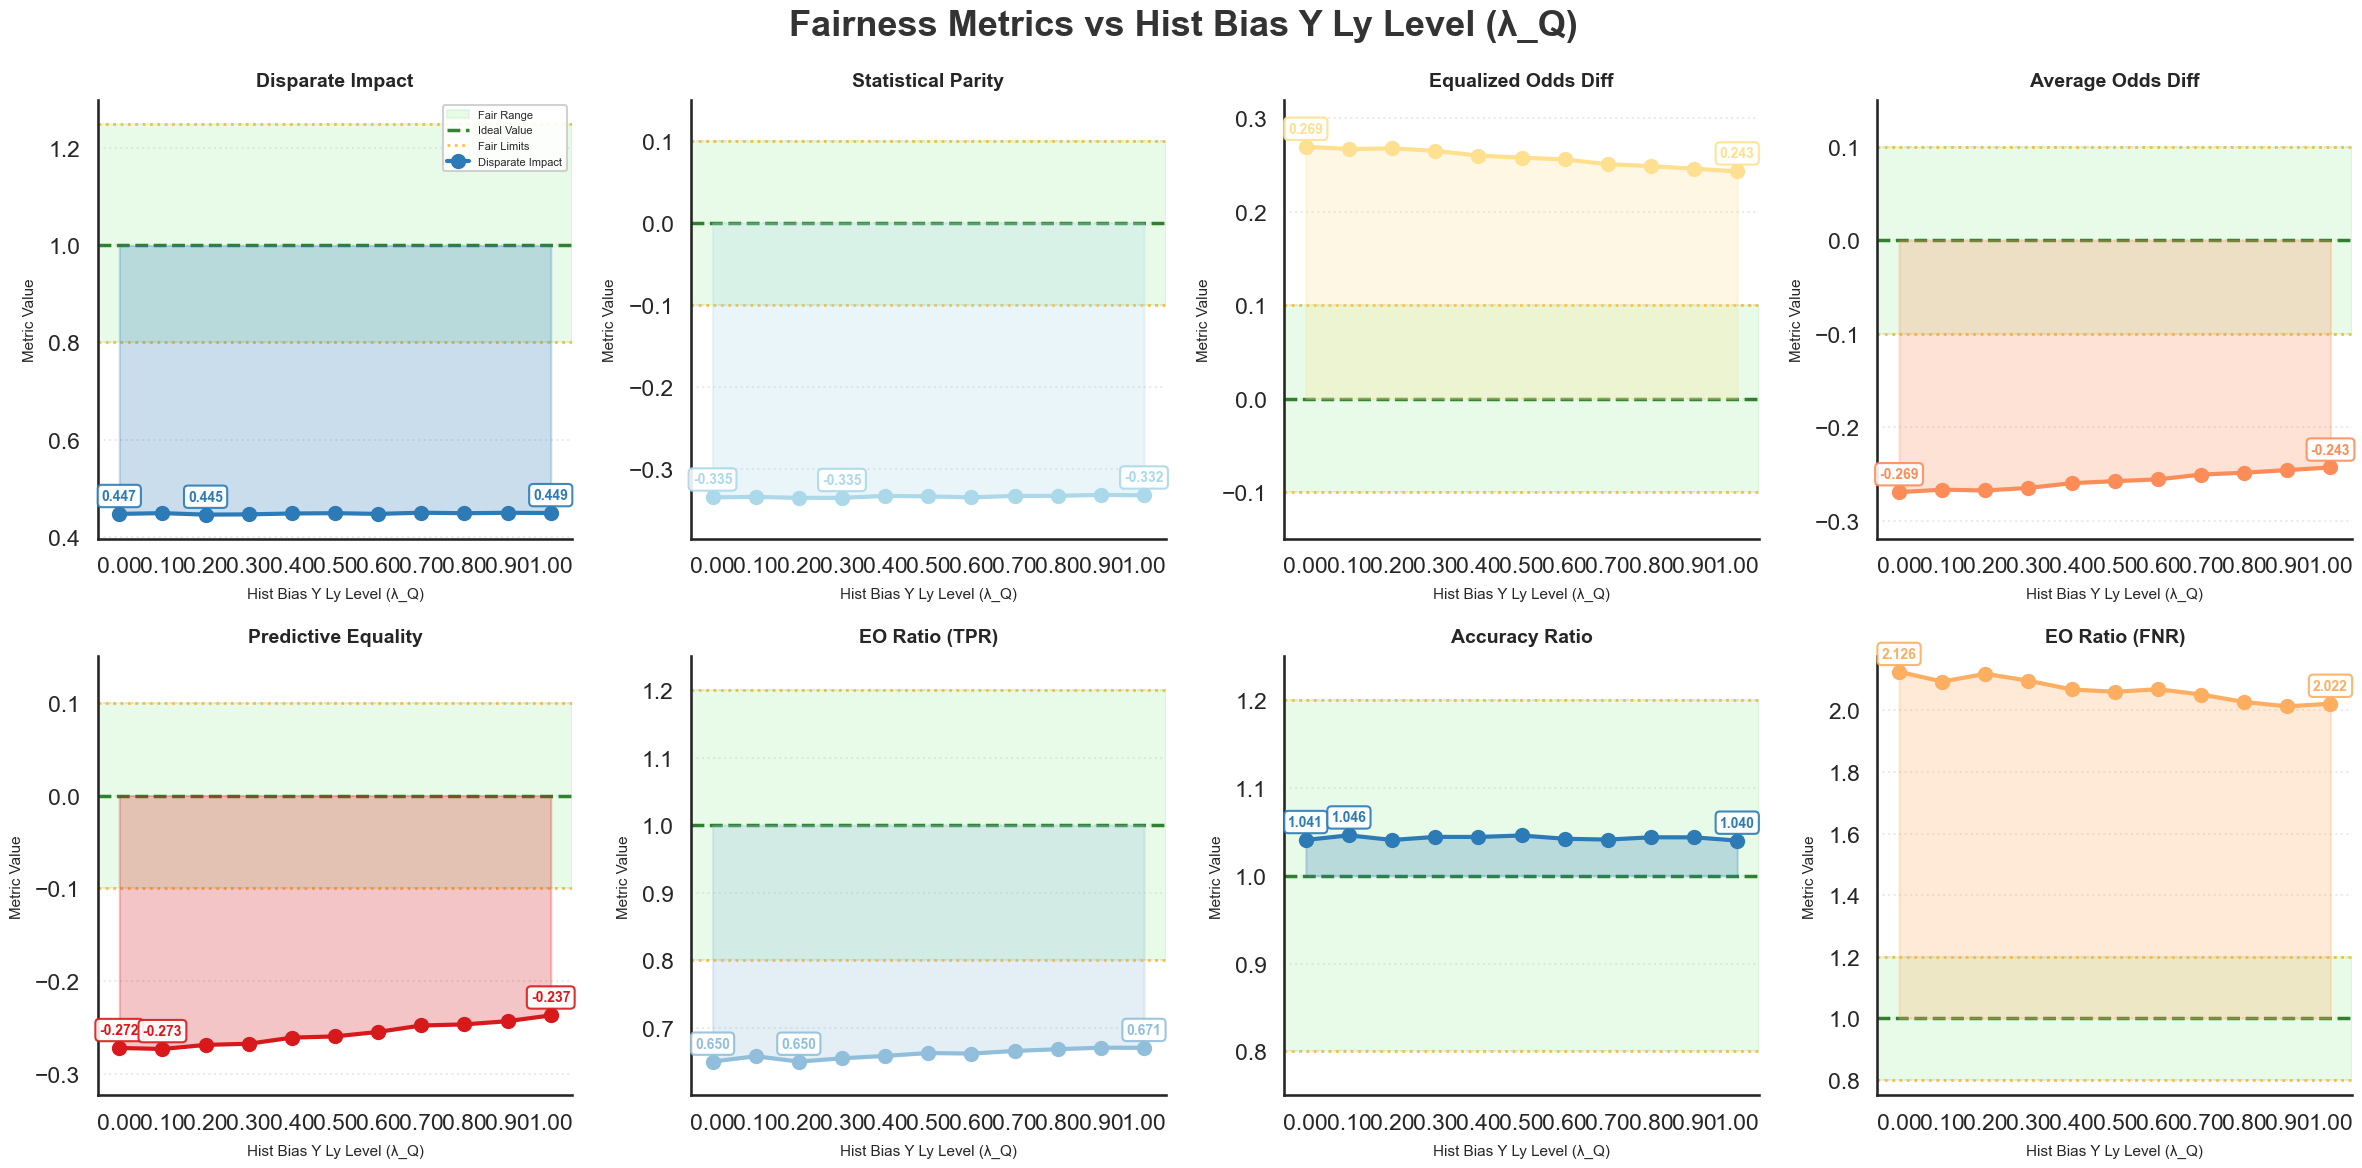

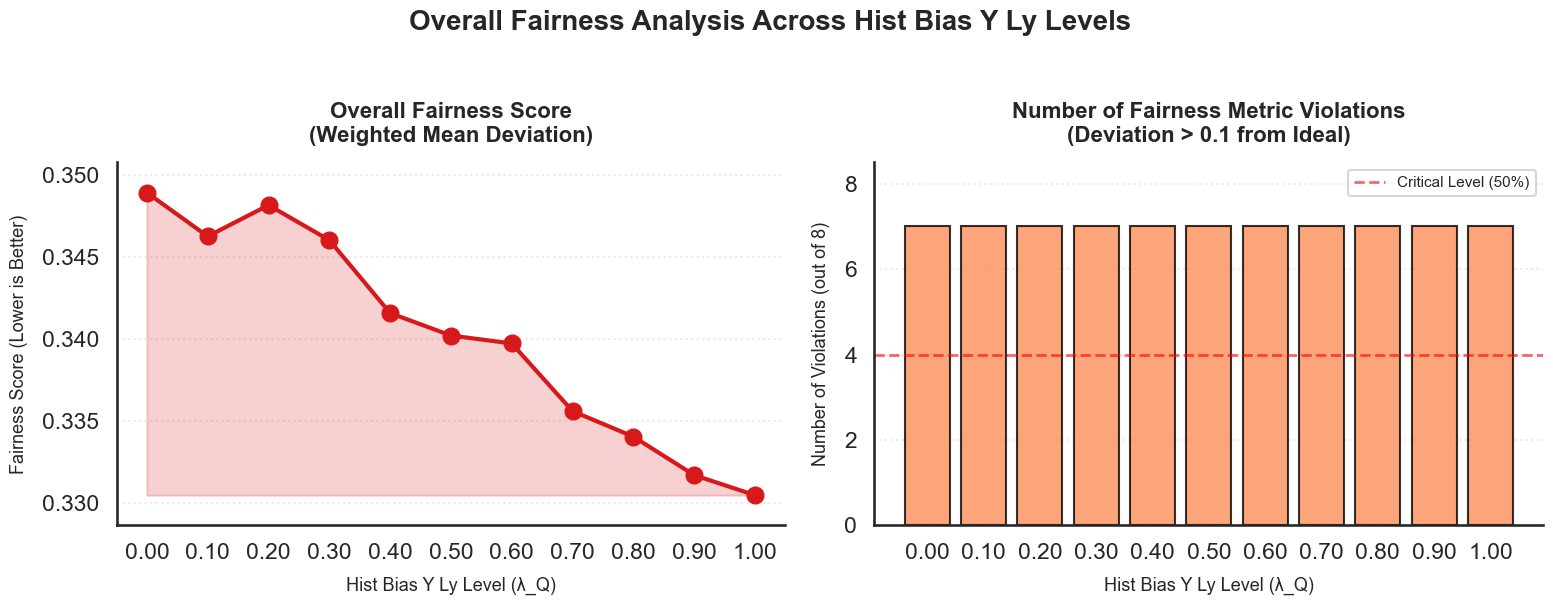

Processing dataset: interaction_bias_lyb
✓ Loaded: results\interaction_bias_lyb_0.00.csv
✓ Loaded: results\interaction_bias_lyb_0.10.csv
✓ Loaded: results\interaction_bias_lyb_0.20.csv
✓ Loaded: results\interaction_bias_lyb_0.30.csv
✓ Loaded: results\interaction_bias_lyb_0.40.csv
✓ Loaded: results\interaction_bias_lyb_0.50.csv
✓ Loaded: results\interaction_bias_lyb_0.60.csv
✓ Loaded: results\interaction_bias_lyb_0.70.csv
✓ Loaded: results\interaction_bias_lyb_0.80.csv
✓ Loaded: results\interaction_bias_lyb_0.90.csv
✓ Loaded: results\interaction_bias_lyb_1.00.csv

✓ Loaded 11 Interaction Bias Lyb levels
✓ Total rows: 11
✓ Interaction Bias Lyb levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


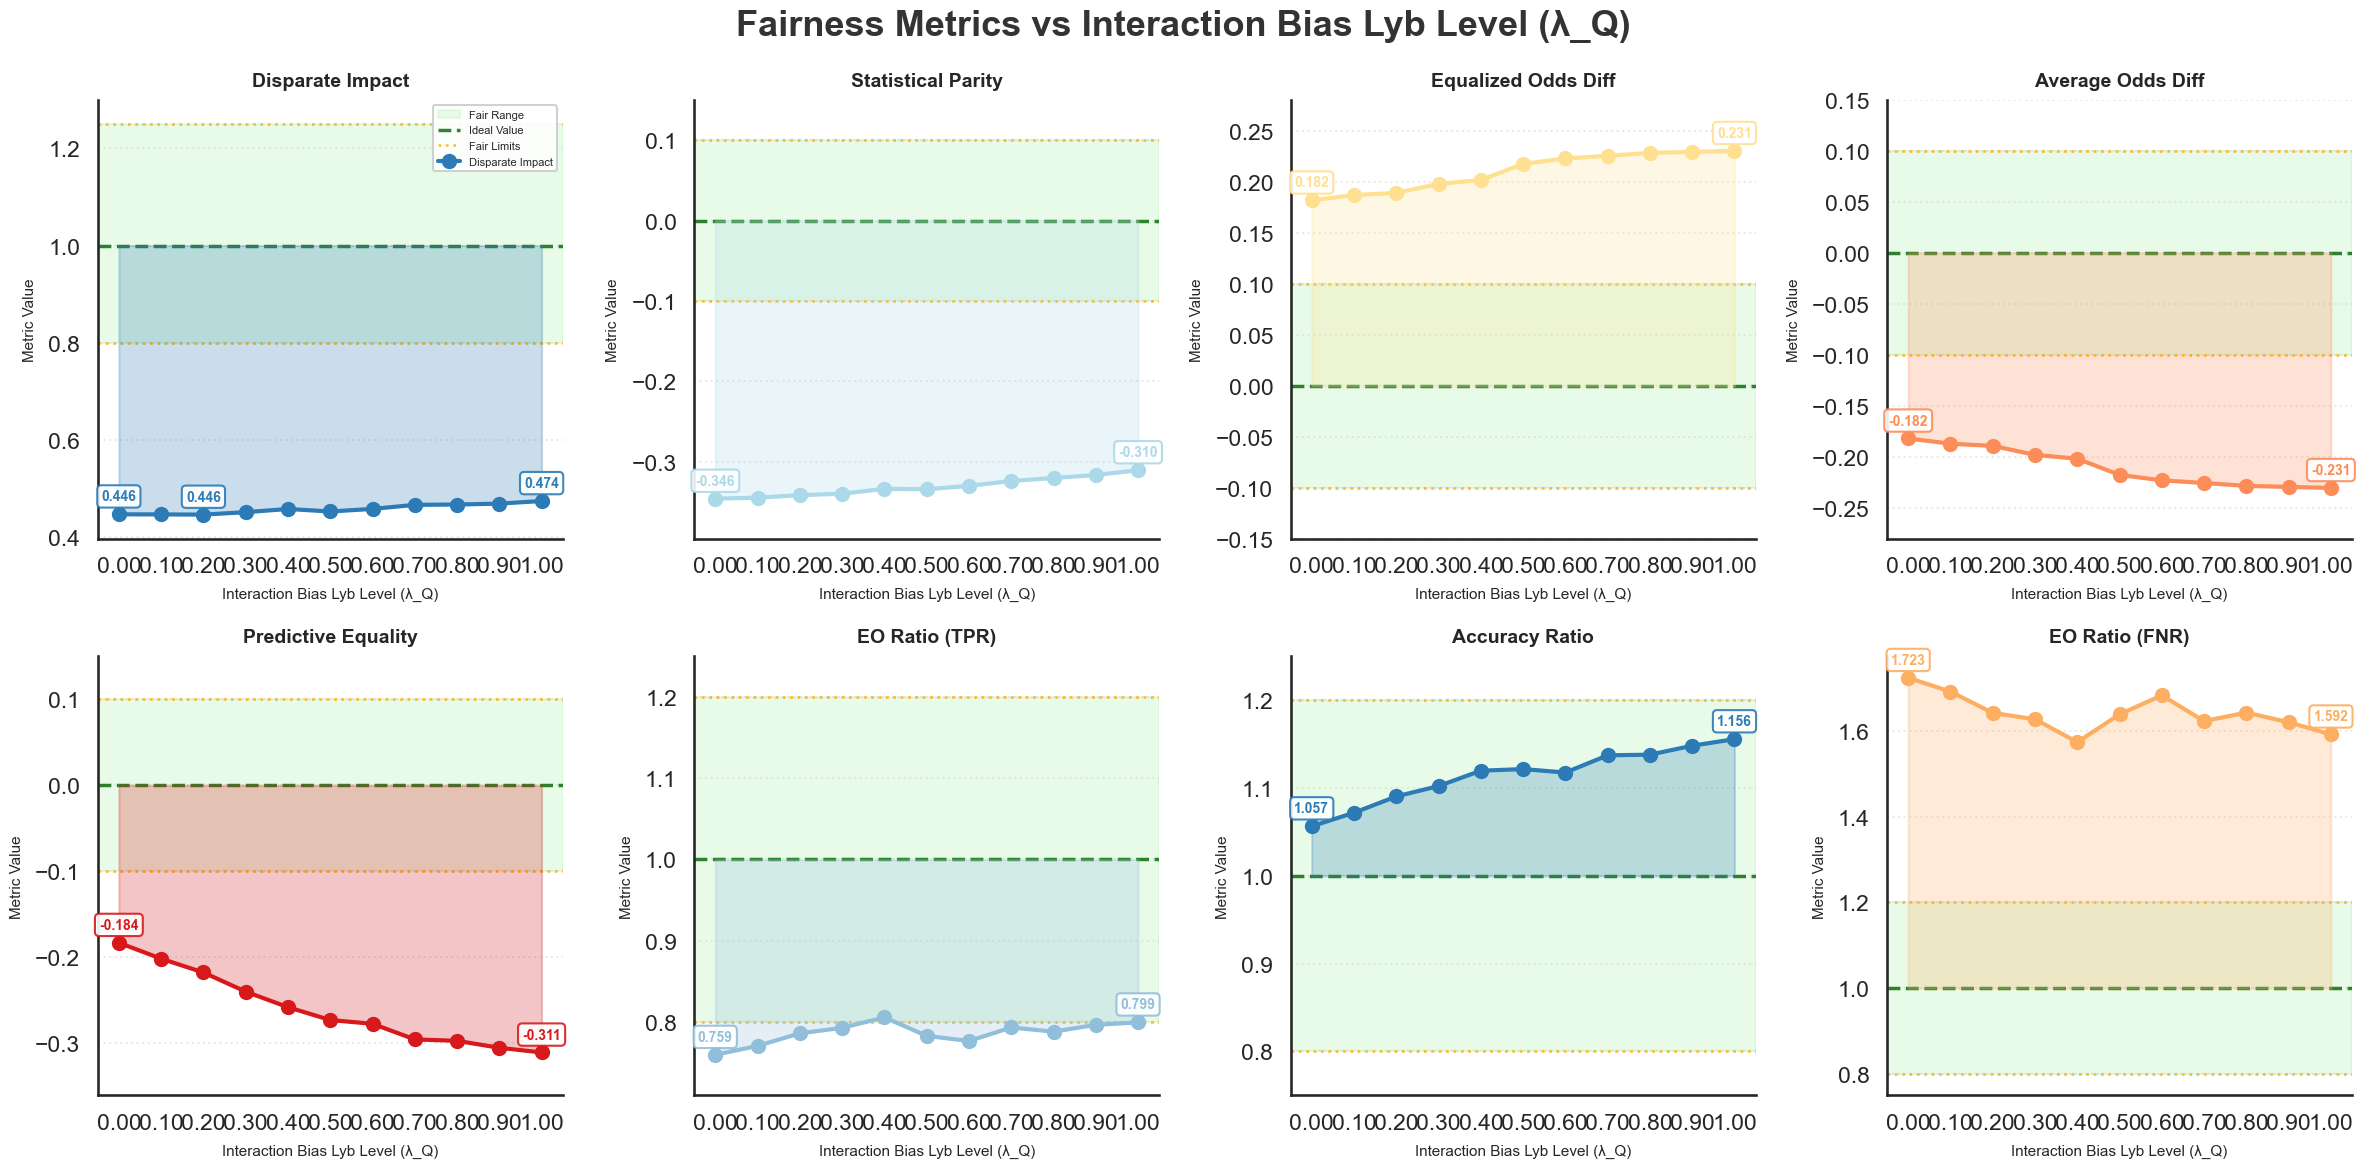

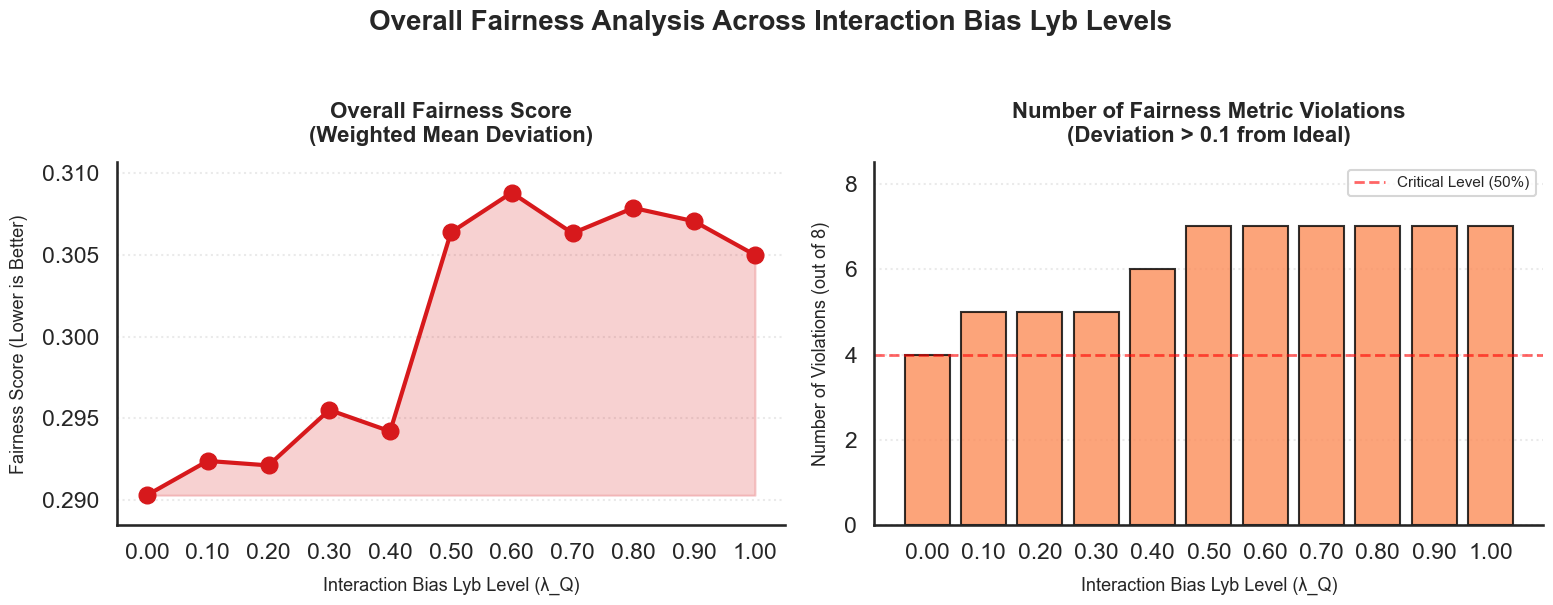

Processing dataset: meas_bias_R_lm
✓ Loaded: results\meas_bias_R_lm_0.00.csv
✓ Loaded: results\meas_bias_R_lm_0.10.csv
✓ Loaded: results\meas_bias_R_lm_0.20.csv
✓ Loaded: results\meas_bias_R_lm_0.30.csv
✓ Loaded: results\meas_bias_R_lm_0.40.csv
✓ Loaded: results\meas_bias_R_lm_0.50.csv
✓ Loaded: results\meas_bias_R_lm_0.60.csv
✓ Loaded: results\meas_bias_R_lm_0.70.csv
✓ Loaded: results\meas_bias_R_lm_0.80.csv
✓ Loaded: results\meas_bias_R_lm_0.90.csv
✓ Loaded: results\meas_bias_R_lm_1.00.csv

✓ Loaded 11 Meas Bias R Lm levels
✓ Total rows: 11
✓ Meas Bias R Lm levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


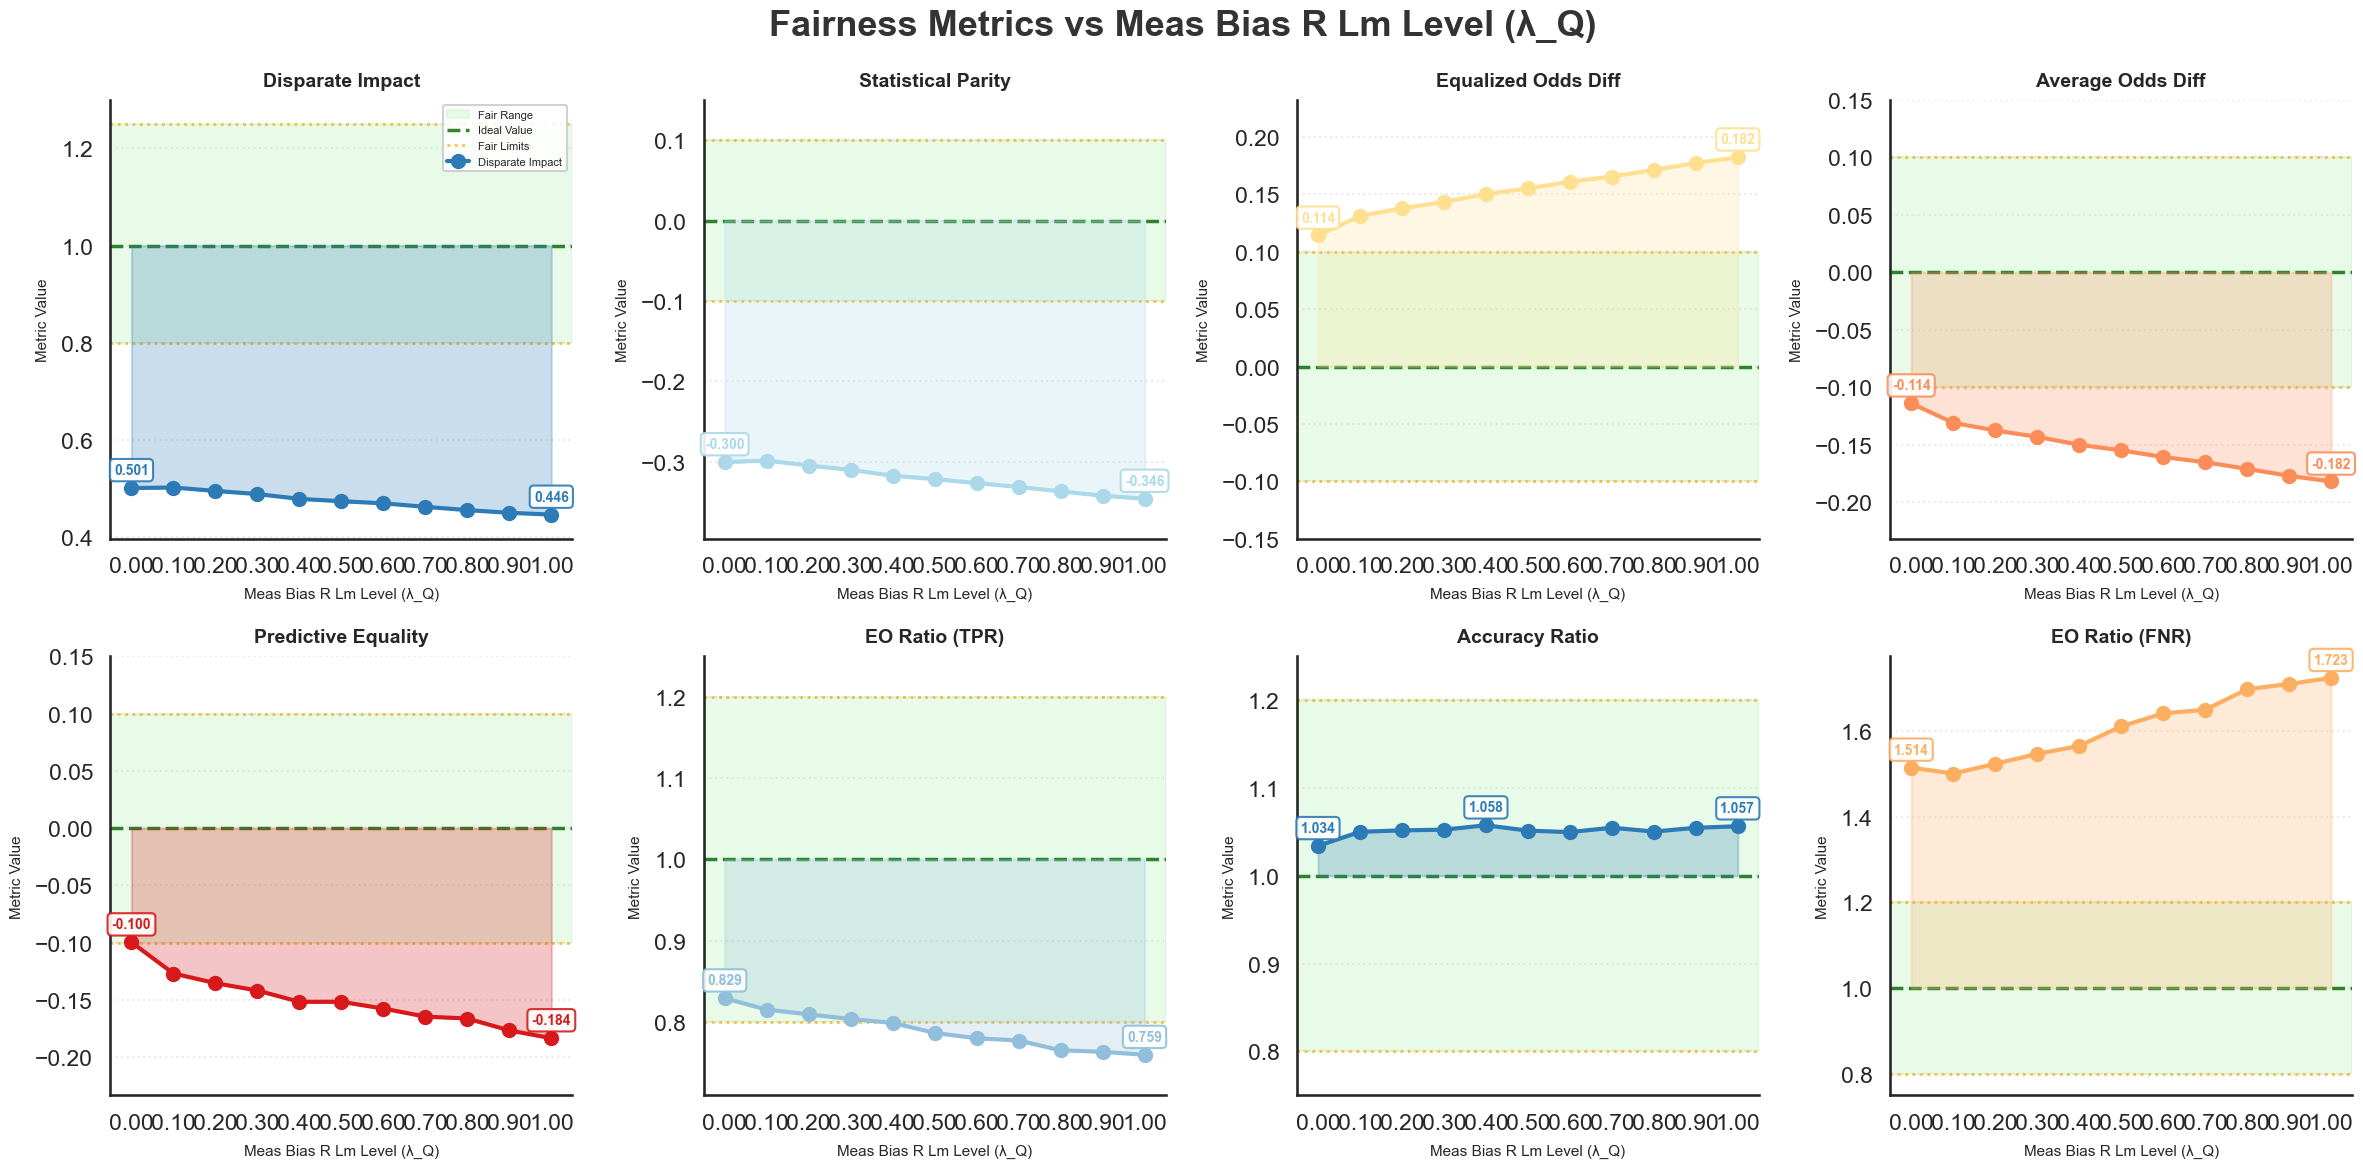

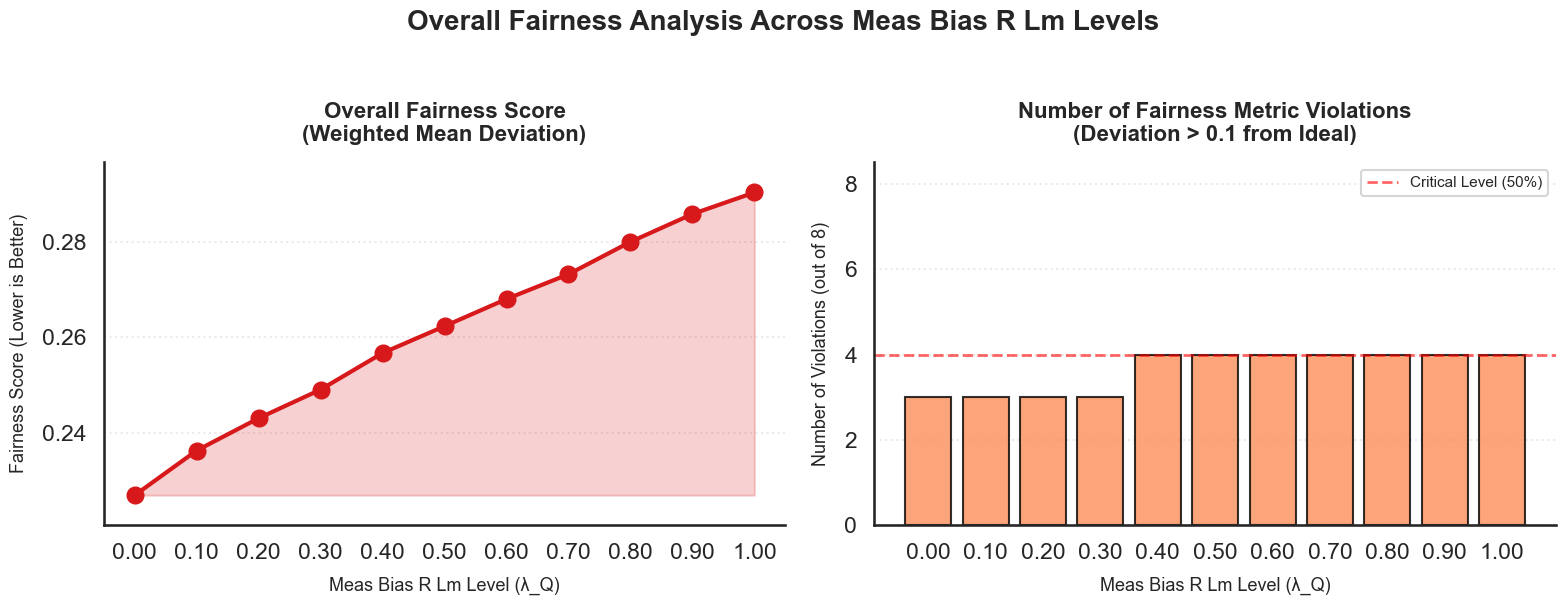

Processing dataset: meas_bias_Y_lmy
✓ Loaded: results\meas_bias_Y_lmy_0.00.csv
✓ Loaded: results\meas_bias_Y_lmy_0.10.csv
✓ Loaded: results\meas_bias_Y_lmy_0.20.csv
✓ Loaded: results\meas_bias_Y_lmy_0.30.csv
✓ Loaded: results\meas_bias_Y_lmy_0.40.csv
✓ Loaded: results\meas_bias_Y_lmy_0.50.csv
✓ Loaded: results\meas_bias_Y_lmy_0.60.csv
✓ Loaded: results\meas_bias_Y_lmy_0.70.csv
✓ Loaded: results\meas_bias_Y_lmy_0.80.csv
✓ Loaded: results\meas_bias_Y_lmy_0.90.csv
✓ Loaded: results\meas_bias_Y_lmy_1.00.csv

✓ Loaded 11 Meas Bias Y Lmy levels
✓ Total rows: 11
✓ Meas Bias Y Lmy levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


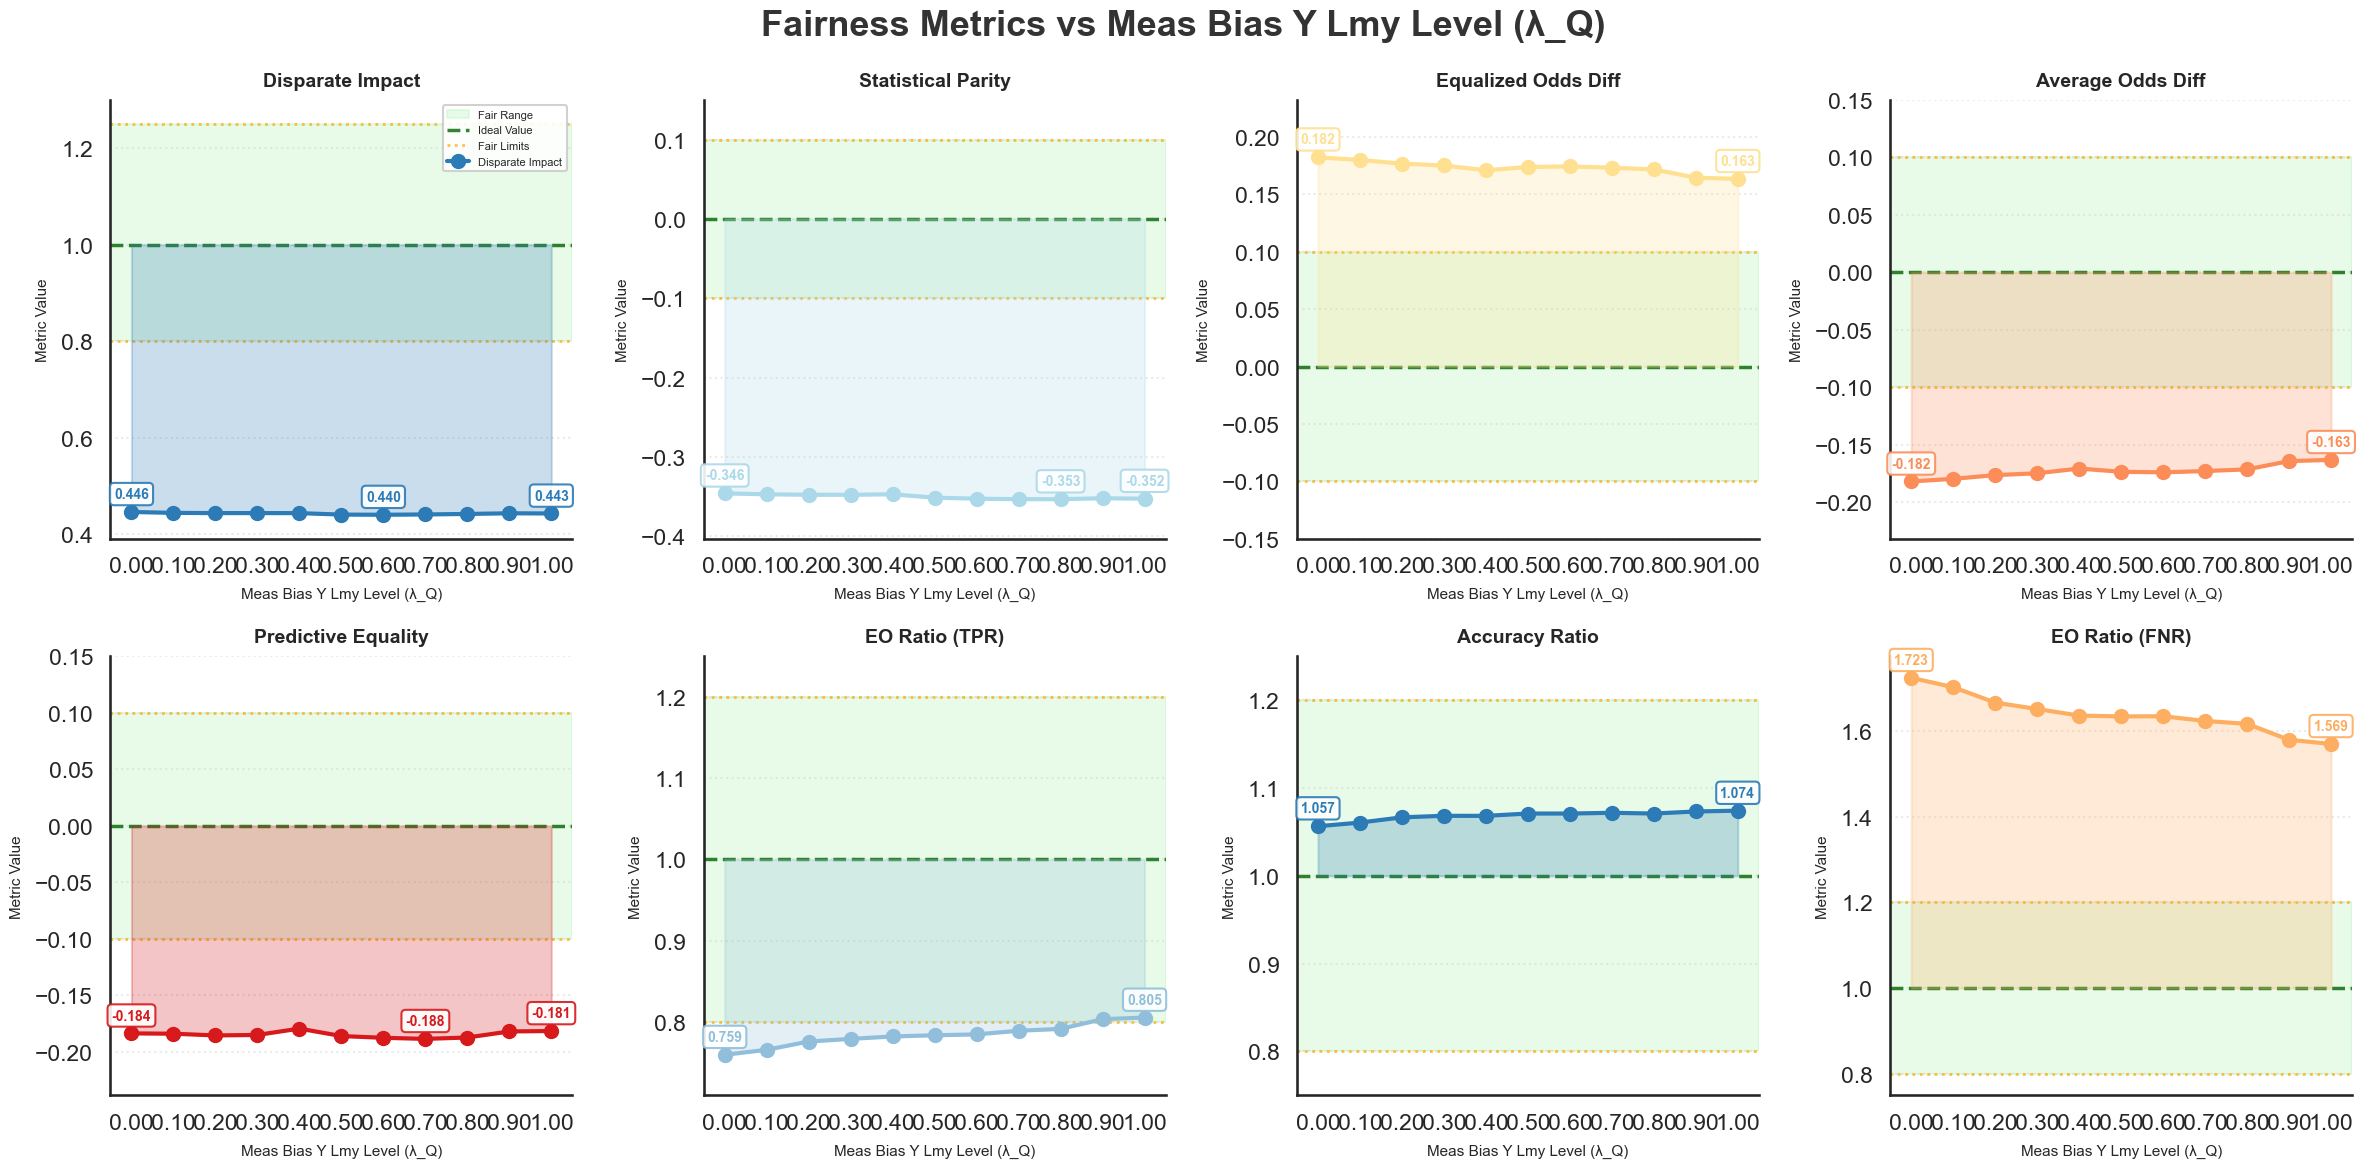

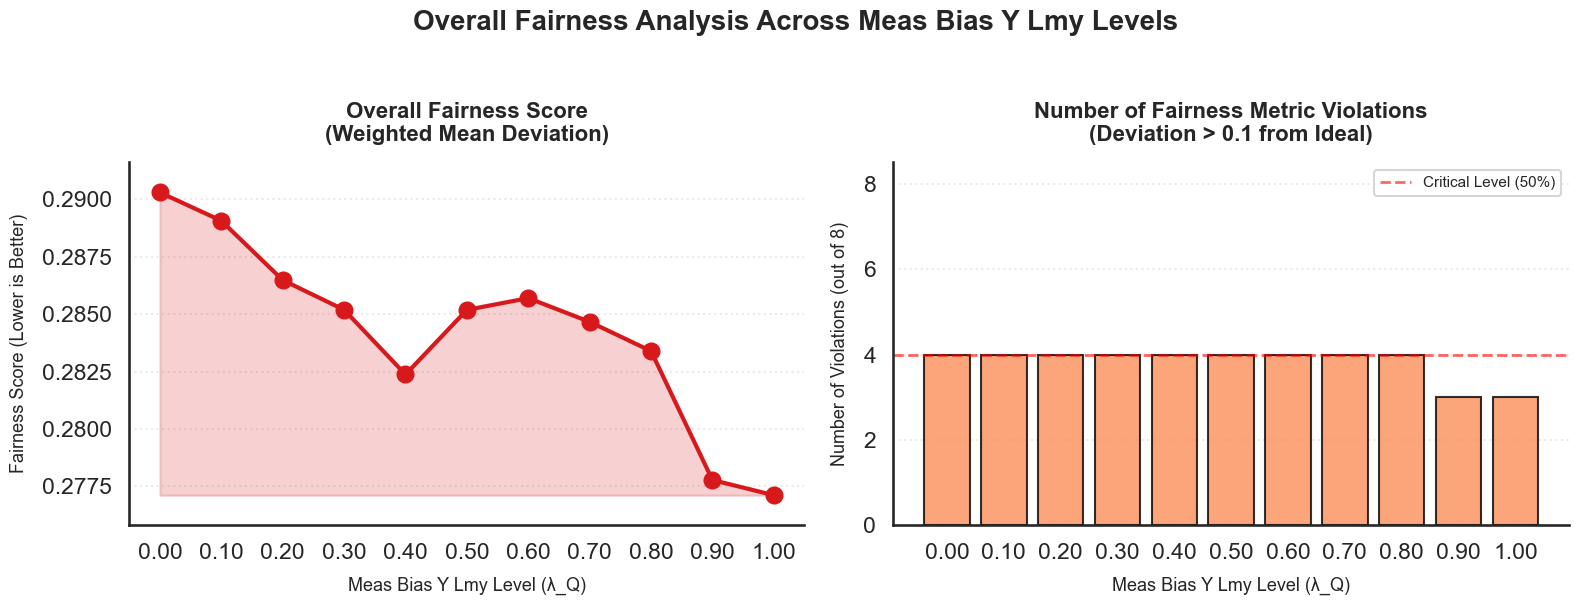

Processing dataset: undersample_pu
✓ Loaded: results\undersample_pu_0.00.csv
✓ Loaded: results\undersample_pu_0.10.csv
✓ Loaded: results\undersample_pu_0.20.csv
✓ Loaded: results\undersample_pu_0.30.csv
✓ Loaded: results\undersample_pu_0.40.csv
✓ Loaded: results\undersample_pu_0.50.csv
✓ Loaded: results\undersample_pu_0.60.csv
✓ Loaded: results\undersample_pu_0.70.csv
✓ Loaded: results\undersample_pu_0.80.csv
✓ Loaded: results\undersample_pu_0.90.csv
✓ Loaded: results\undersample_pu_1.00.csv

✓ Loaded 11 Undersample Pu levels
✓ Total rows: 11
✓ Undersample Pu levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


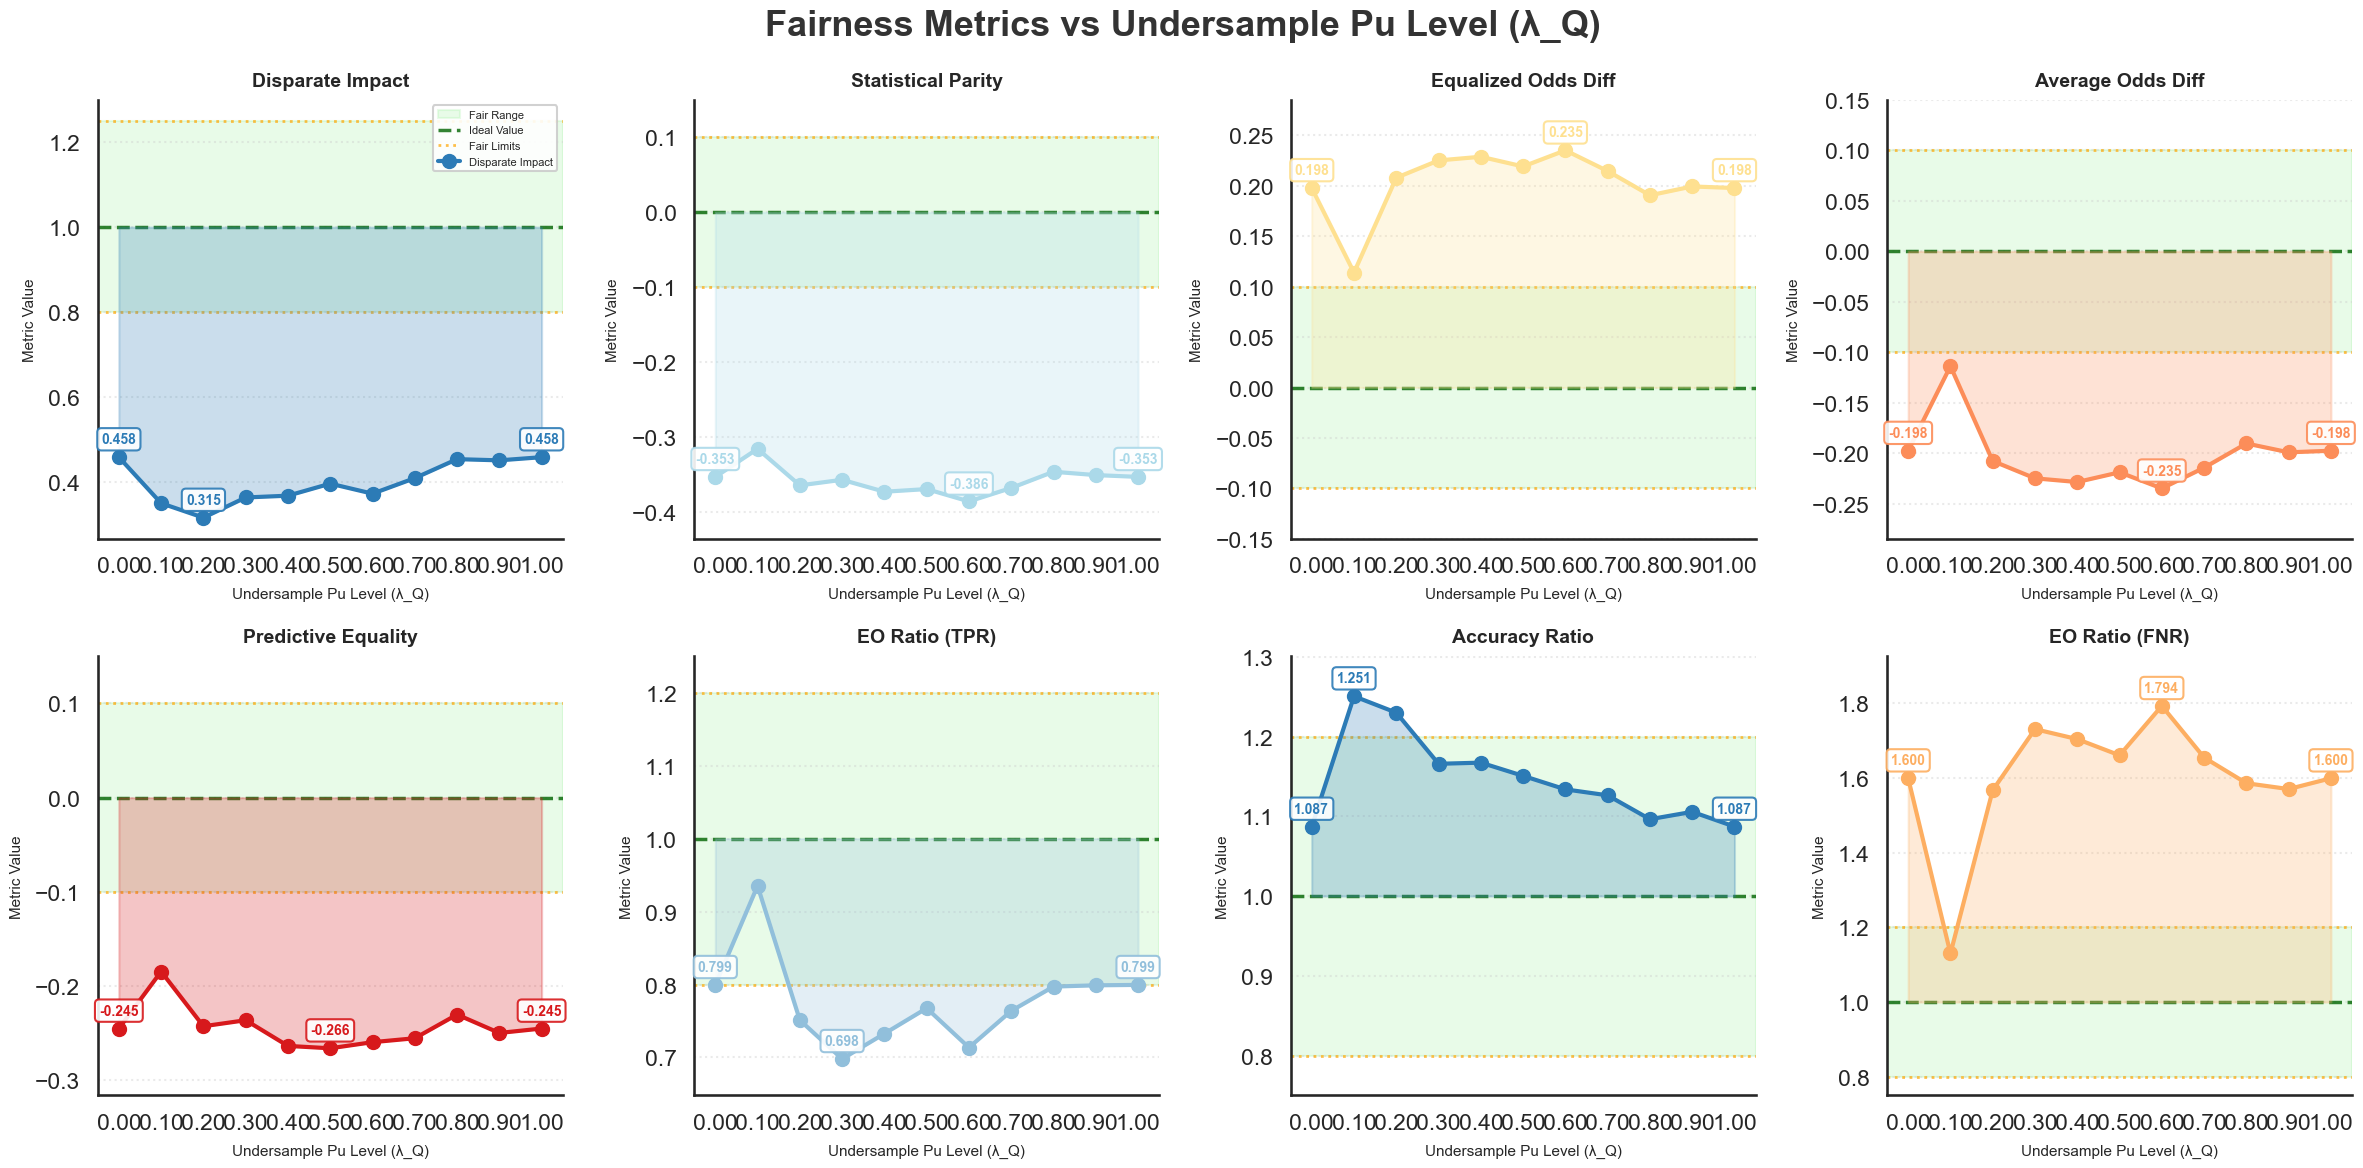

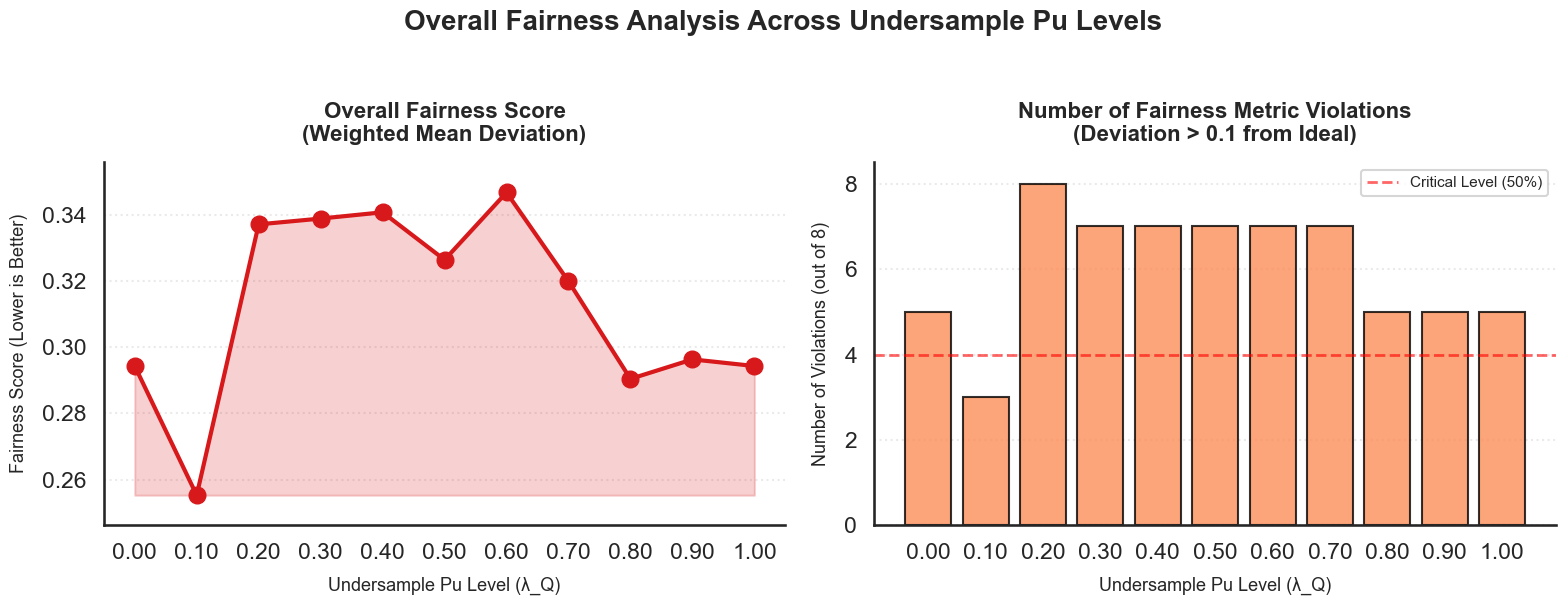

Processing dataset: label_noise_sy
✓ Loaded: results\label_noise_sy_0.00.csv
✓ Loaded: results\label_noise_sy_0.10.csv
✓ Loaded: results\label_noise_sy_0.20.csv
✓ Loaded: results\label_noise_sy_0.30.csv
✓ Loaded: results\label_noise_sy_0.40.csv
✓ Loaded: results\label_noise_sy_0.50.csv
✓ Loaded: results\label_noise_sy_0.60.csv
✓ Loaded: results\label_noise_sy_0.70.csv
✓ Loaded: results\label_noise_sy_0.80.csv
✓ Loaded: results\label_noise_sy_0.90.csv
✓ Loaded: results\label_noise_sy_1.00.csv

✓ Loaded 11 Label Noise Sy levels
✓ Total rows: 11
✓ Label Noise Sy levels: ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']


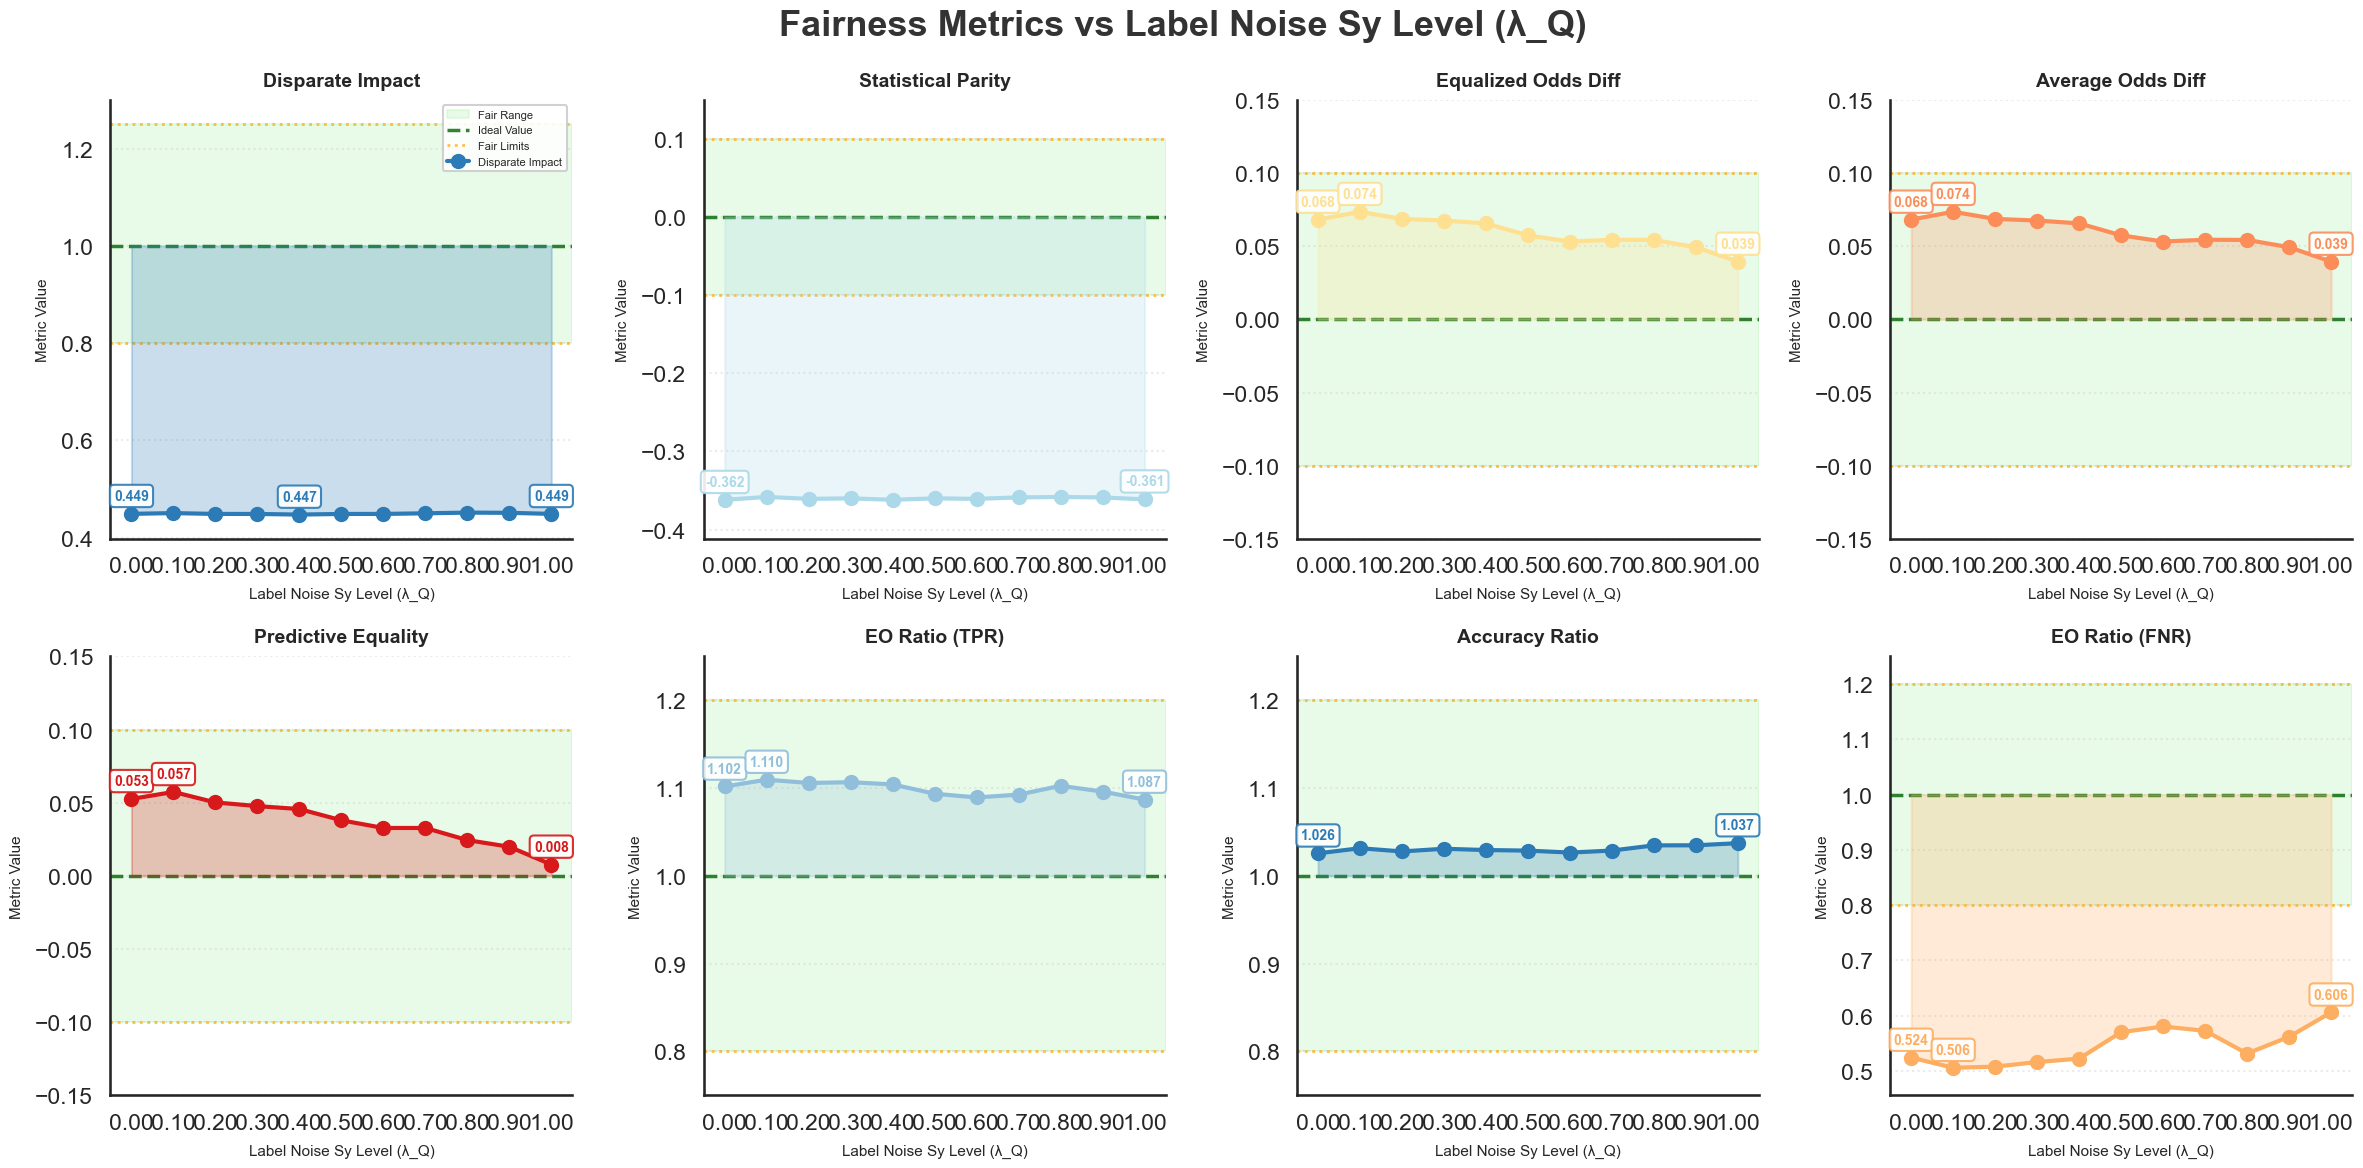

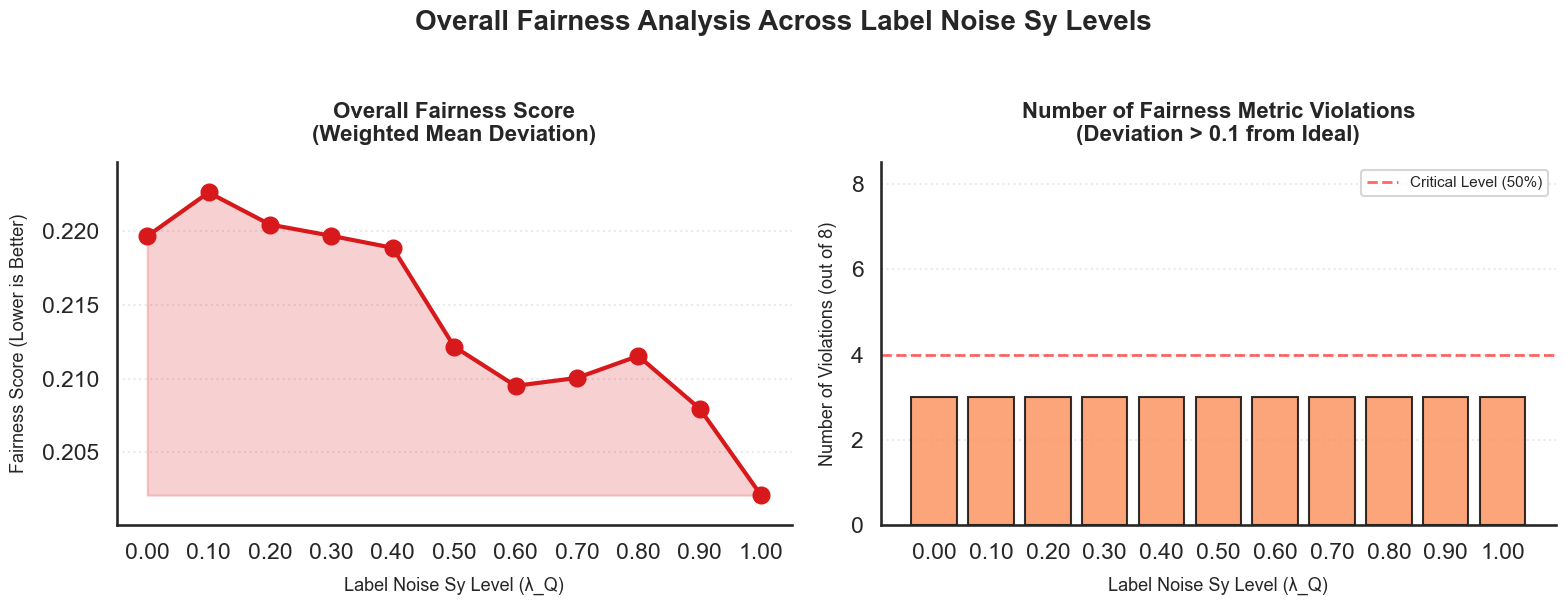

In [5]:
"""
Fairness Metrics Visualization Across Bias Levels
==================================================

This script loads fairness evaluation results from multiple bias levels
and creates professional visualizations comparing all 8 fairness metrics.
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from fairness_help import calculate_overall_fairness_score

# --- Visualization Setup - Professional Style ---
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# --- Data Loading Function ---

def load_fairness_results(condition, path, bias_levels, results_dir='results'):
    """
    Load fairness results from multiple bias level CSVs.
    
    Parameters:
    -----------
    bias_levels : list
        List of bias levels to load (e.g., [0.0, 0.1, 0.2, ...])
    results_dir : str
        Directory containing the CSV files
        
    Returns:
    --------
    pd.DataFrame : Combined results from all bias levels
    """
    all_data = []
    
    for bias_level in bias_levels:
        filepath = Path(results_dir) / f'{path}{bias_level}.csv'
        
        try:
            df = pd.read_csv(filepath)
            df['bias_level'] = bias_level  # Add bias level column
            all_data.append(df)
            print(f"✓ Loaded: {filepath}")
        except FileNotFoundError:
            print(f"✗ Not found: {filepath}")
            continue
    
    if not all_data:
        raise ValueError(f"No data files found! Check your results directory and {condition} levels.")
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Filter to only non-reference group (the group being compared)
    # Typically this is where group != reference_group
    combined_df = combined_df[combined_df['group'] != combined_df['reference_group']]
    
    print(f"\n✓ Loaded {len(all_data)} {condition} levels")
    print(f"✓ Total rows: {len(combined_df)}")
    print(f"✓ {condition} levels: {sorted(combined_df['bias_level'].unique())}")
    
    return combined_df

# --- Main Plotting Function ---

def plot_fairness_metrics_comparison(condition, df):
    # Define the 8 fairness metrics with their ideal values, colors, and acceptable ranges
    # Format: (column, label, ideal_value, color, acceptable_range)
    metrics_config = [
        ('DI', 'Disparate Impact', 1.0, '#2c7bb6', (0.8, 1.25)),
        ('SP', 'Statistical Parity', 0.0, '#abd9e9', (-0.1, 0.1)),
        ('EOD', 'Equalized Odds Diff', 0.0, '#fee090', (-0.1, 0.1)),
        ('AOD', 'Average Odds Diff', 0.0, '#fc8d59', (-0.1, 0.1)),
        ('PE', 'Predictive Equality', 0.0, '#d7191c', (-0.1, 0.1)),
        ('EOR_TPR', 'EO Ratio (TPR)', 1.0, '#91bfdb', (0.8, 1.2)),
        ('ACC', 'Accuracy Ratio', 1.0, '#2c7bb6', (0.8, 1.2)),
        ('EOR_FNR', 'EO Ratio (FNR)', 1.0, '#fdae61', (0.8, 1.2)),     
    ]
    
    # Create figure with 2 rows, 4 columns (8 subplots total)
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()
    
    # Main title
    fig.suptitle(f'Fairness Metrics vs {condition} Level (λ_Q)', 
                 fontsize=26, fontweight='bold', color='#333333', y=0.98)
    
    # Sort by bias level for proper line plotting
    df_sorted = df.sort_values('bias_level')
    
    # Plot each metric
    for idx, (col, label, ideal_value, color, acceptable_range) in enumerate(metrics_config):
        ax = axes[idx]
        
        # Extract data
        x = df_sorted['bias_level']
        y = df_sorted[col]
        
        # 1. Draw acceptable range as shaded area (fair zone)
        ax.axhspan(acceptable_range[0], acceptable_range[1], 
                   color='lightgreen', alpha=0.2, zorder=0, label='Fair Range')
        
        # 2. Draw the ideal/reference line (thicker, darker)
        ax.axhline(ideal_value, color='darkgreen', linestyle='--', linewidth=2.5, 
                   alpha=0.8, zorder=1, label='Ideal Value')
        
        # 3. Draw acceptable threshold lines
        ax.axhline(acceptable_range[0], color='orange', linestyle=':', 
                  linewidth=2, alpha=0.7, zorder=1, label='Fair Limits')
        ax.axhline(acceptable_range[1], color='orange', linestyle=':', 
                  linewidth=2, alpha=0.7, zorder=1)
        
        # 4. Draw the main metric line with markers
        ax.plot(x, y, marker='o', markersize=10, linewidth=3, 
                color=color, label=label, zorder=3)
        
        # 5. Fill area between curve and ideal to show deviation
        ax.fill_between(x, y, ideal_value, color=color, alpha=0.25)
        
        # 6. Annotate key points (first, last, and worst deviation)
        idx_max_dev = (y - ideal_value).abs().idxmax()
        points_to_annotate = [y.index[0], y.index[-1]]
        if idx_max_dev not in points_to_annotate:
            points_to_annotate.append(idx_max_dev)
        
        for i in points_to_annotate:
            val = df_sorted.loc[i, col]
            bias_val = df_sorted.loc[i, 'bias_level']
            ax.annotate(f'{val:.3f}', xy=(bias_val, val), 
                       xytext=(0, 10), textcoords='offset points',
                       ha='center', fontsize=10, fontweight='bold', 
                       color=color, bbox=dict(boxstyle='round,pad=0.3', 
                       facecolor='white', edgecolor=color, alpha=0.9))
        
        # 7. Styling
        ax.set_title(label, fontsize=14, pad=10, fontweight='bold')
        ax.set_xlabel(f'{condition} Level (λ_Q)', fontsize=11, labelpad=8)
        ax.set_ylabel('Metric Value', fontsize=11, labelpad=8)
        ax.grid(axis='y', linestyle=':', alpha=0.4)
        
        # 8. ZOOM: Set y-limits dynamically based on data range
        data_range = y.max() - y.min()
        data_margin = max(data_range * 0.2, 0.05)  # At least 20% margin or 0.05
        
        # Consider both data range and acceptable range
        y_min = min(y.min() - data_margin, acceptable_range[0] - 0.05)
        y_max = max(y.max() + data_margin, acceptable_range[1] + 0.05)
        
        ax.set_ylim(y_min, y_max)
        
        # Add legend for first plot only (avoid clutter)
        if idx == 0:
            ax.legend(loc='best', fontsize=8, framealpha=0.9)
    
    plt.tight_layout()
    return fig

# --- Deviation from Ideal Summary Plot ---

def plot_overall_fairness_summary(condition, df):
    """
    Plot overall fairness score (mean deviation from ideal) across bias levels.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Combined fairness results
    """
    # Calculate overall fairness score for each bias level
    metrics_deviations = []
    
    for bias_level in sorted(df['bias_level'].unique()):
        subset = df[df['bias_level'] == bias_level].iloc[0]
        
        # Calculate deviations from ideal
        deviations = [
            abs(subset['ACC'] - 1.0),
            abs(subset['PE'] - 0.0),
            abs(subset['EOR_FNR'] - 1.0),
            abs(subset['SP'] - 0.0),
            abs(subset['DI'] - 1.0),
            abs(subset['EOD'] - 0.0),
            abs(subset['EOR_TPR'] - 1.0),
            abs(subset['AOD'] - 0.0)
        ]
        
        overall_score = subset['overall_fairness_score']
        
        metrics_deviations.append({
            'bias_level': bias_level,
            'overall_fairness_score': overall_score,
            'num_violations': sum(1 for d in deviations if d > 0.2)  # Count significant violations
        })
    
    summary_df = pd.DataFrame(metrics_deviations)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Overall Fairness Score (ZOOMED on data range)
    ax1.plot(summary_df['bias_level'], summary_df['overall_fairness_score'],
             marker='o', markersize=12, linewidth=3, color='#d7191c')
    ax1.fill_between(summary_df['bias_level'], 
                     summary_df['overall_fairness_score'], 
                     summary_df['overall_fairness_score'].min(), 
                     color='#d7191c', alpha=0.2)
    
    # ZOOM: Set y-limits based on data range only
    score_range = summary_df['overall_fairness_score'].max() - summary_df['overall_fairness_score'].min()
    margin = max(score_range * 0.1, 0.001)  # 10% margin
    ax1.set_ylim(summary_df['overall_fairness_score'].min() - margin,
                 summary_df['overall_fairness_score'].max() + margin)
    
    ax1.set_title('Overall Fairness Score\n(Weighted Mean Deviation)', 
                  fontsize=16, fontweight='bold', pad=15)
    ax1.set_xlabel(f'{condition} Level (λ_Q)', fontsize=13, labelpad=10)
    ax1.set_ylabel('Fairness Score (Lower is Better)', fontsize=13, labelpad=10)
    ax1.grid(axis='y', linestyle=':', alpha=0.4)
    
    # Plot 2: Number of Violations
    ax2.bar(summary_df['bias_level'], summary_df['num_violations'],
            color='#fc8d59', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.axhline(4, color='red', linestyle='--', linewidth=2, 
                alpha=0.6, label='Critical Level (50%)')
    ax2.set_title('Number of Fairness Metric Violations\n(Deviation > 0.1 from Ideal)', 
                  fontsize=16, fontweight='bold', pad=15)
    ax2.set_xlabel(f'{condition} Level (λ_Q)', fontsize=13, labelpad=10)
    ax2.set_ylabel('Number of Violations (out of 8)', fontsize=13, labelpad=10)
    ax2.set_ylim(0, 8.5)
    ax2.grid(axis='y', linestyle=':', alpha=0.4)
    ax2.legend(fontsize=11)
    
    fig.suptitle(f'Overall Fairness Analysis Across {condition} Levels', 
                 fontsize=20, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    return fig

# --- Main Execution ---

def main(condition, path):

    levels = ['0.00', '0.10', '0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00']
    df = load_fairness_results(condition, path, levels, results_dir='results')
    fig1 = plot_fairness_metrics_comparison(condition, df)
    fig2 = plot_overall_fairness_summary(condition, df)
    plt.show()


if __name__ == "__main__":
    datasets = [
        'hist_bias_Q_lq',
        'hist_bias_R_lhr',
        'hist_bias_Y_ly',
        'interaction_bias_lyb',
        'meas_bias_R_lm',
        'meas_bias_Y_lmy',
        'undersample_pu',
        #'representation_bias_lr_true',
        #'omitted_var_bias_lo_true',
        'label_noise_sy',
    ]
    for d in datasets:
        print(f"Processing dataset: {d}")
        main(condition=d.replace('_', ' ').title(), path=f"{d}_")
